# Random Forest Regression: 
## The regression algorithm for complicated nonlinear problems where you don't know where to start

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.datasets import make_regression, load_boston
from sklearn.model_selection import cross_val_score
from statsmodels.api import OLS
from scipy.stats import pearsonr,spearmanr

In [2]:
np.random.seed(0)
plt.rcParams.update({'font.size':16, 'figure.figsize':(10,8)})

### When you want the search power of decision trees

### But you want to predict measurment values and not classes

### Then you might want Random Forest Regression

![rf-average-trees](https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png)

### At the bottom of each decision tree is a measurement prediction instead of a class prediction

### The final prediction is the average of the predictions from all the trees

In [3]:
def random_data(n_samples=100,n_features=100,n_informative=10):
    X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_informative, random_state=0, shuffle=False)
    X = pd.DataFrame(X,columns=['x%d'%(i+1) for i in range(n_features)])
    y = pd.DataFrame(y,columns=['y'])
    return X,y

In [4]:
X,y = random_data(n_samples=50,n_features=8,n_informative=4)
y.join(X).head()

,y,x1,x2,x3,x4,x5,x6,x7,x8
0,313.036448,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,0.950088,-0.151357
1,149.520495,-0.103219,0.410599,0.144044,1.454274,0.761038,0.121675,0.443863,0.333674
2,-30.317098,1.494079,-0.205158,0.313068,-0.854096,-2.552990,0.653619,0.864436,-0.742165
3,-16.546222,2.269755,-1.454366,0.045759,-0.187184,1.532779,1.469359,0.154947,0.378163
4,-95.656827,-0.887786,-1.980796,-0.347912,0.156349,1.230291,1.202380,-0.387327,-0.302303


In [5]:
linear_fit = OLS(y,X).fit()
linear_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.591e+30
Date:                Sun, 01 Apr 2018   Prob (F-statistic):               0.00
Time:                        22:11:21   Log-Likelihood:                 1424.7
No. Observations:                  50   AIC:                            -2833.
Df Residuals:                      42   BIC:                            -2818.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            20.4924   1.67e-14   1.22e+15      0.000      20.492      20.492
x2            34.1698    1.6e-14   2.13e+15      0.000      34.170      34.170
x3            67.6242   2.08e-14   3.25e+15      0.000      67.624      67.624
x4            87.9235   1.87e-14   4.71e+15      0.000      87.923      87.923
x5         -3.375e-14   1.48e-14     -2.279      0.028   -6.36e-14   -3.87e-15
x6         -2.794e-14   1.84e-14     -1.520      0.136    -6.5e-14    9.15e-15
x7          3.553e-15   1.71e-14      0.208      0.836    -3.1e-14    3.81e-14
x8         -1.776e-15   1.64e-14     -0.109      0.914   -3.48e-14    3.12e-14
==============================================================================
Omnibus:                        3.047   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.396
Skew:                           0.397   Prob(JB):                        0.302
Kurtosis:                       2.279   Cond. No.                         1.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Perform a simple linear regression on this data

In [6]:
lm = LinearRegression()
lm.fit(X,y);

## Perform a random forest regression on this data

In [7]:
rfr = RandomForestRegressor(n_estimators=25)
rfr.fit(X,y);

In [8]:
def importance_vs_coefficient(lm,rfr):
    n = len(lm.coef_.T)
    plt.scatter(lm.coef_,rfr.feature_importances_,s=300,c='w')
    plt.xlabel('Linear regression coefficients')
    plt.ylabel('Random forest importance scores')
    for i in range(n):
       plt.annotate('%d'%(i+1), (lm.coef_.T[i]+2*np.random.rand(),
                                  rfr.feature_importances_[i]+0.05*np.random.rand()),
                                  color='red',size=18)
    plt.title('Comparison of linear regression coefficients\nand random forest importance scores')

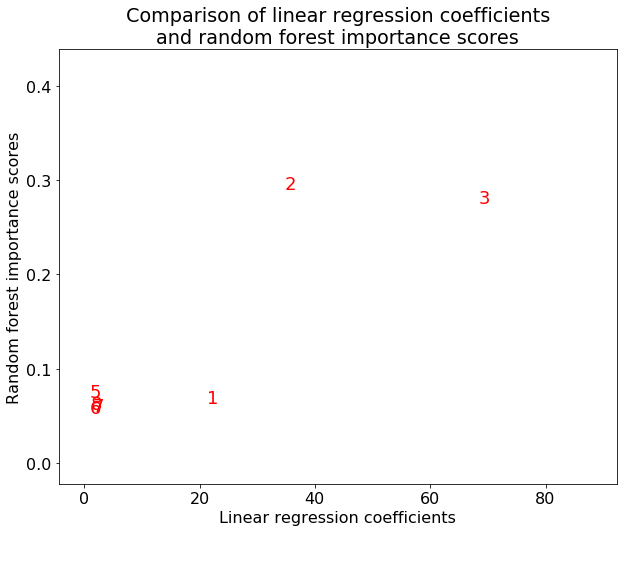

In [9]:
importance_vs_coefficient(lm,rfr)

In [10]:
def plot_importance_correlation(values):
    plt.pcolor(values.mean(axis=2),cmap='RdBu_r',vmin=-1,vmax=1)
    plt.xticks(0.5+np.arange(n),powers_of_2)
    plt.yticks(0.5+np.arange(n),powers_of_2)
    plt.xlabel('Number of features (variables)')
    plt.ylabel('Number of observations (samples)')
    plt.colorbar().set_label('Spearman correlation R')
    plt.title('Correlation between linear model coefficients\nand random forest feature importances')

In [11]:
powers_of_2 = 2**np.arange(2,10)
n = len(powers_of_2)
n_iterations = 3
importance_correlation = np.empty((n,n,n_iterations))
cross_validation_performance_linear = np.empty((n,n,n_iterations))
cross_validation_performance_forest = np.empty((n,n,n_iterations))
for k in range(n_iterations):
    print('Iteration %d...' % (k+1))
    for i,n_samples in enumerate(powers_of_2):
        for j,n_features in enumerate(powers_of_2):
            X,y = random_data(n_samples=n_samples,n_features=n_features,n_informative=4)
            y_ = y.values.ravel()
            lm.fit(X,y_)
            rfr.fit(X,y_)
            r = spearmanr(lm.coef_,rfr.feature_importances_)[0]
            importance_correlation[i,j,k] = r
            cross_validation_performance_linear[i,j,k] = cross_val_score(lm,X,y_).mean()
            cross_validation_performance_forest[i,j,k] = cross_val_score(rfr,X,y_).mean()

Iteration 1...
Iteration 2...
Iteration 3...


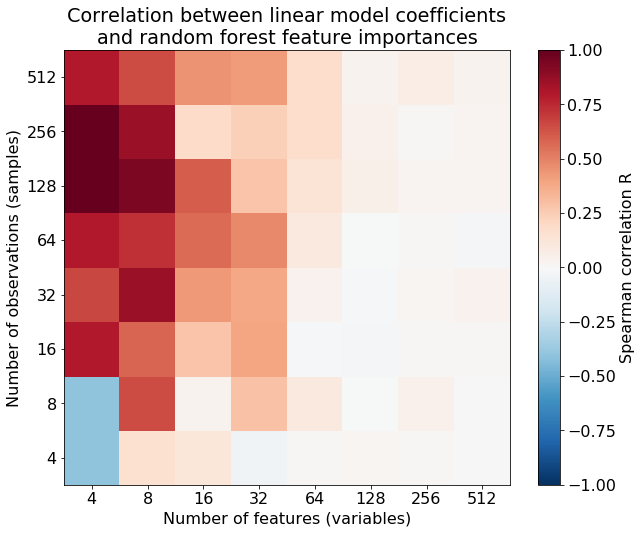

In [12]:
plot_importance_correlation(importance_correlation)

## Let's try this out an a real (non-neuroscience) dataset

In [13]:
boston = load_boston()
target = pd.DataFrame(boston.target,columns=['Median Housing Price'])
features = pd.DataFrame(boston.data,columns=boston.feature_names)
target.join(features).head()

,Median Housing Price,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [14]:
def scorer(est,X,y):
    """Computes the Pearson correlation between predicted and observed values"""
    predicted = est.predict(X).squeeze()
    actual = y.squeeze()
    if predicted.var()==0:
        r = 0
    else:
        r,p = pearsonr(predicted,actual)    
    return r

## First, try ordinary linear regression

In [15]:
cross_val_scores = cross_val_score(lm,features,target,cv=25,scoring=scorer)
print("Linear regression:")
print("Correlation between predicted and actual values is %.2f +/- %.2f" % (cross_val_scores.mean(),cross_val_scores.std()))

Linear regression:
Correlation between predicted and actual values is 0.73 +/- 0.18


## What about the Lasso?  It should do better than ordinary linear regression

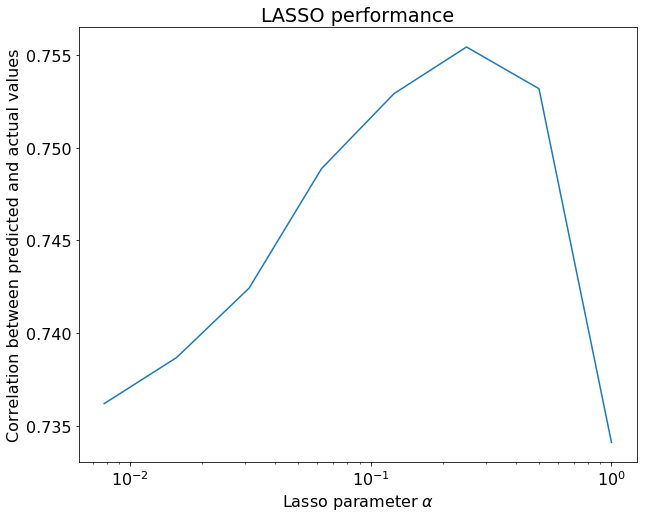

In [16]:
alphas = 2.0**np.arange(-7,1)
cross_val_scores = np.empty_like(alphas)
for i,alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha)
    cross_val_scores[i] = cross_val_score(lasso,features,target,cv=25,scoring=scorer).mean()
plt.plot(alphas,cross_val_scores)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$')
plt.ylabel('Correlation between predicted and actual values');
plt.title('LASSO performance');

## Can Random Forest Regression do better still?

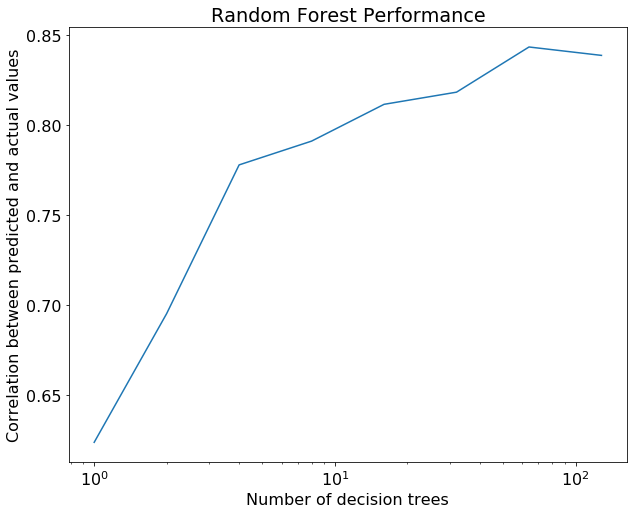

In [17]:
num_estimators = 2**np.arange(0,8)
cross_val_scores = np.empty_like(num_estimators).astype('float')
for i,n_estimators in enumerate(num_estimators):
    rfr = RandomForestRegressor(n_estimators=n_estimators,max_features=4)
    cross_val_scores[i] = cross_val_score(rfr,features,target,cv=25,scoring=scorer).mean()
plt.plot(num_estimators,cross_val_scores)
plt.xscale('log')
plt.xlabel('Number of decision trees')
plt.ylabel('Correlation between predicted and actual values')
plt.title('Random Forest Performance');

## Random Forest usually does much better than linear regression if there are a lot of nonlinearities and interactions

### However, if the underlying structure of the relationship is linear, some variant of linear regression will usually still be your best choice

In [18]:
def plot_cross_validation_performance(values,title):
    plt.pcolor(values.mean(axis=2),cmap='RdBu_r',vmin=-1,vmax=1)
    plt.xticks(0.5+np.arange(n),powers_of_2)
    plt.yticks(0.5+np.arange(n),powers_of_2)
    plt.xlabel('Number of features (variables)')
    plt.ylabel('Number of observations (samples)')
    plt.colorbar().set_label('Out-of-sample correlation between\npredictions and actual values')
    plt.title(title)

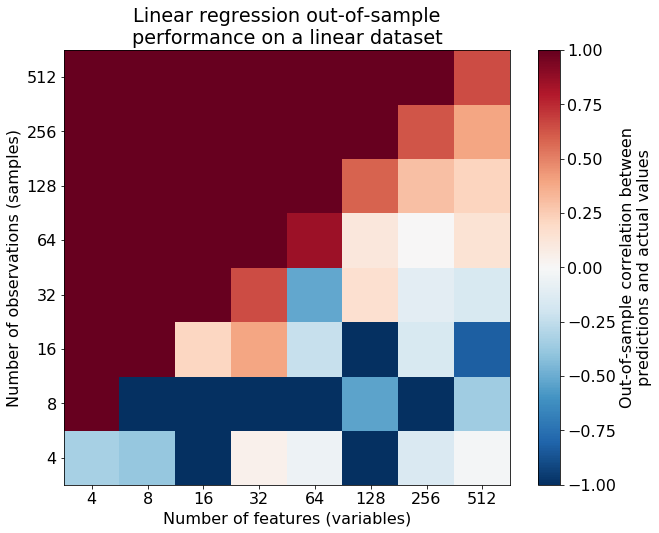

In [21]:
plot_cross_validation_performance(cross_validation_performance_linear,"Linear regression out-of-sample\nperformance on a linear dataset")

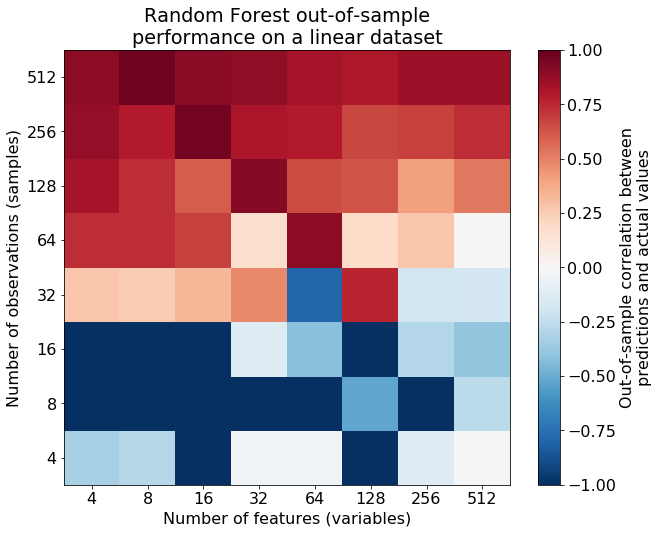

In [23]:
plot_cross_validation_performance(cross_validation_performance_forest,"Random Forest out-of-sample\nperformance on a linear dataset")